Lab02
=====

## Context
#### CNN Exercise
+ Tensorflow Speech Recognition
+ Pretrained Model Exercise

## 음성 데이터를 2차원 CNN으로 분류해보기
오늘 배운 2차원 CNN을 이용해 음성 데이터를 분류하는 모델을 만들어보겠습니다.<br> 
음성 데이터는 1차원의 데이터라고 생각드실 수 있지만, 푸리에 변환이라는 방법을 사용해 스펙트로그램 이미지로 변환할 수 있습니다.<br>
물론, Convolution을 1차원으로 수행할 수 있습니다만 지금 배운 내용은 2차원이므로 이미지로 변환하여 수행해보겠습니다.<br>

In [1]:
#path 관련 라이브러리
import os
from os.path import isdir, join

# Scientific Math 라이브러리  
import numpy as np
from scipy import signal
from scipy.io import wavfile
from sklearn.model_selection import train_test_split

# Visualization 라이브러리
import matplotlib.pyplot as plt
import IPython.display as ipd

import keras
from keras import layers, Input
from keras import models
import tensorflow as tf

datapath = join('data', join('Tensorflow_Speech_Recognition', 'audio'))

Using TensorFlow backend.


In [2]:
# Keras 백 엔드인 TensorFlow의 세션 설정을 불러옵니다.
from keras.backend.tensorflow_backend import set_session

# TensorFlow의 ConfigProto() 객체에 학습시 적용할 옵션들을 명시적으로 설정할 수 있습니다.
config = tf.ConfigProto()
# GPU 옵션으로 allow_grouth를 True로 설정합니다.
config.gpu_options.allow_growth = True 

# TensorFlow는 Session이라는 실행 단위를 가지고 있는데, 해당 Session이라는에 적용할 옵션을 담고있는 Config객체를 전달합니다.
sess = tf.Session(config=config)
# 설정한 Session이라는을 현재 프로세스에 적용합니다.
set_session(sess)  

## 1. 데이터 살펴보기
이번에 사용할 데이터는 위에서 말씀드린 Tensorflow Speech Recognition Challenge 입니다.<br>
작년 1월에 Kaggle 플랫폼에서 진행된 Competition의 데이터셋입니다. 구글 AI에서 제공한 데이터입니다.<br>
해당 데이터는 31개의 클래스를 가지고 있고, 학습 데이터 기준 클래스 당 약 2천개의 데이터를 가지고 있어 총 6만개의 데이터로 이루어져 있습니다.<br>
해당 대회는 31개 클래스 중 10개의 Target Label과 나머지 20개의 Unknown Label, 그리고 마지막 Silence Label을 분류하는 것을 목표로 하고 있습니다.

Target Label : yes, no, up, down, left, right, on, off, stop, go

Unknown Label : 
'bed', 'bird', 'cat', 'dog', 'eight', 'five', 'four', 'happy', 'house',<br>
'marvin', 'nine', 'one', 'seven', 'sheila', 'six', 'three', 'tree', 'two', 'wow', 'zero'

Silence Label : '_background\_noise\_'

<img src = "./Images/Tensorflow_Speech_Recognition.png" style = height:600px/>
<br><br>
data 디렉토리에 준비된 데이터와 라벨을 가져옵니다.<br> 

In [3]:
# 데이터 샘플 불러오기
filename = join('no', 'c4e1f6e0_nohash_2.wav')
sample_rate, samples = wavfile.read(join(datapath ,filename))
print('Wav 형태일 때 차원 : {}'.format(samples.shape))
ipd.Audio(samples, rate= sample_rate)

Wav 형태일 때 차원 : (16000,)


## 2. 데이터 전처리
먼저 1차원 wav 데이터를 푸리에 변환을 통해 2차원 스펙트로그램으로 저장합니다.<br>
스펙트로그램으로 변환하는 함수는 미리 작성해 두었습니다.

In [4]:
# 음성 파일을 스펙트로그램으로 변환하는 함수
def log_specgram(audio, sample_rate, window_size=20, step_size = 10,
                eps = 1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                           fs = sample_rate,
                                           window='hann',
                                           nperseg = nperseg,
                                           noverlap=noverlap,
                                           detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [5]:
#스펙트로 그램 변환 및 차원 확인
freqs, times, spectrogram = log_specgram(samples, sample_rate)
freqs_size = len(freqs)
times_size = len(times)

1차원 데이터인 Wav 데이터를 2차원 데이터인 스펙트로그램으로 변환시키고 확인해보겠습니다.

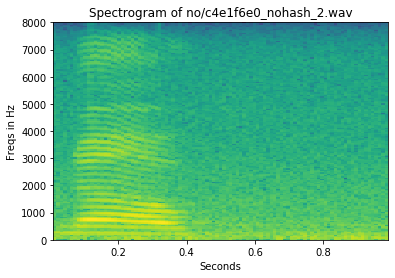

Spectrogram 형태일 때 차원 : (99, 161)


In [6]:
plt.imshow(spectrogram.T, aspect='auto', origin='lower',
          extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.title('Spectrogram of ' + filename)
plt.ylabel('Freqs in Hz')
plt.xlabel('Seconds')
plt.show()
print('Spectrogram 형태일 때 차원 : {}'.format(spectrogram.shape))

In [7]:
# os.listdir(경로) 함수는 경로에 존재하는 모든 파일 이름을 리스트로 반환합니다.
dirs = [f for f in os.listdir(datapath) if isdir(join(datapath, f))]
dirs.sort()

In [8]:
#데이터 읽기
target_value = dict()
x = list()
y = list()
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
i=0;
for direct in dirs[1:]:
    if direct not in target_list:
        continue
    # 각 디렉토리에 대해 파일명 리스트를 만듭니다.
    waves = [f for f in os.listdir(join(datapath, direct)) if f.endswith('.wav')]
    target_value[direct] = i
    i = i + 1
    print(str(i)+":" +str(direct) + " ", end="")
    
    #만든 파일명 리스트를 바탕으로 음성 파일을 읽습니다.
    for wav in waves:
        sample_rate, samples = wavfile.read(datapath+'/'+direct+'/'+wav)
        if samples.shape[0] != 16000 :
            continue
        # 읽은 음성 파일을 2차원 스펙트로그램 이미지로 변환하여 저장합니다.
        freqs, times, spec = log_specgram(samples,sample_rate)
        spec = (spec - spec.min())/(spec.max() - spec.min())
        
        x.append(spec.T)
        y.append(direct)

1:down 2:go 3:left 4:no 5:off 6:on 7:right 8:stop 9:up 10:yes 

스펙트로그램으로 변환하면 채널이라는 개념이 없기 때문에, 차원을 재구성하면서 마지막 채널 1개를 추가해줍니다.<br>
그리고 지금 y값에는 라벨이 아닌 범주형 데이터로 이루어져 있으므로 먼저 숫자 라벨로 변경 후 독립적인 벡터 형태로 표현하겠습니다.<br>
### 왜 벡터를 사용하나요
여기에서 Label 데이터를 그대로 숫자로 표현해도 되지만, 벡터로 표현한 것은 숫자 이미지라는 특성이 수치적으로 1씩 증가하는 관계가 아니기 때문에<br>
서로 독립적인 관계를 갖는 벡터로 표현해주는 것이 더 적절합니다. 이러한 기법을 One-hot encoding이라 합니다.<br>
Keras에서는 연속 정수형을 벡터형태로 변환해주는 to_categorical() 함수가 존재합니다.

In [9]:
x = np.reshape(x, (-1, freqs_size, times_size, 1))

In [10]:
# 레이블을 숫자형태로 변경
temp = []
for v in y:
    temp.append(target_value[v])
y = np.array(temp)

# 레이블을 one hot encoding으로 변환
y = keras.utils.to_categorical(y, len(target_value))

In [11]:
# 데이터를 훈련 데이터와, 검증 데이터로 나눕니다.
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2,
                                                    random_state = 2019,
                                                    shuffle=True)

In [12]:
print('x_train 차원 : ' + str(np.shape(x_train)))

print('y_train 차원 : ' + str(np.shape(y_train)))

print('x_test 차원 : ' + str(np.shape(x_test)))

print('y_test 차원 : ' + str(np.shape(y_test)))

x_train 차원 : (479, 161, 99, 1)
y_train 차원 : (479, 10)
x_test 차원 : (120, 161, 99, 1)
y_test 차원 : (120, 10)


In [13]:
# 파라미터 설정
lr = 0.001
epoch = 10
batch_size = 256
drop_out_rate = 0.5

## 3. CNN 모델 작성해보기
오늘 배운 내용을 바탕으로 2차원 CNN 모델을 자유롭게 작성해 보세요.

In [14]:
# 입력층
input_shape = (x_train[0].shape)
input_tensor = layers.Input(input_shape)

In [15]:
# 은닉층
conv_layer_1 = layers.Conv2D(32, (3,3), activation = 'relu')(input_tensor)
pool_layer_1 = layers.MaxPooling2D()(conv_layer_1)
drop_out_layer_1 = layers.Dropout(0.5)(pool_layer_1)
batch_normal_1 = layers.BatchNormalization()(drop_out_layer_1)

conv_layer_2 = layers.Conv2D(64, (3,3), activation = 'relu')(batch_normal_1)
pool_layer_2 = layers.MaxPooling2D()(conv_layer_2)
drop_out_layer_2 = layers.Dropout(0.5)(pool_layer_2)
batch_normal_2 = layers.BatchNormalization()(drop_out_layer_2)

conv_layer_3 = layers.Conv2D(128, (3,3), activation = 'relu')(batch_normal_2)
pool_layer_3 = layers.MaxPooling2D()(conv_layer_3)
drop_out_layer_3 = layers.Dropout(0.5)(pool_layer_3)
batch_normal_3 = layers.BatchNormalization()(drop_out_layer_3)

conv_layer_4 = layers.Conv2D(256, (3,3), activation = 'relu')(batch_normal_3)
pool_layer_4 = layers.MaxPooling2D()(conv_layer_4)
drop_out_layer_4 = layers.Dropout(0.5)(pool_layer_4)
batch_normal_4 = layers.BatchNormalization()(drop_out_layer_4)

flat = layers.Flatten()(batch_normal_4)

dense_layer_1 = layers.Dense(512, activation='relu')(flat)
drop_out_layer_5 = layers.Dropout(0.5)(dense_layer_1)
batch_normal_5 = layers.BatchNormalization()(drop_out_layer_5)

dense_layer_2 = layers.Dense(256, activation='relu')(batch_normal_5)
drop_out_layer_6 = layers.Dropout(0.5)(dense_layer_2)
batch_normal_6 = layers.BatchNormalization()(drop_out_layer_6)

dense_layer_3 = layers.Dense(128, activation='relu')(batch_normal_6)
drop_out_layer_7 = layers.Dropout(0.5)(dense_layer_3)
batch_normal_7 = layers.BatchNormalization()(drop_out_layer_7)

#출력층
output_tensor = layers.Dense(10, activation='softmax')(batch_normal_7)

In [16]:
# 모델 정의
model = models.Model(input_tensor, output_tensor)
# 모델 생성(컴파일) optimizer를 이런식으로 직접 넣을 수도 있습니다.
model.compile(optimizer = keras.optimizers.Adam(lr = lr),
              # 범주 분류이므로 categorical_crossentropy
             loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 161, 99, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 159, 97, 32)       320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 79, 48, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 79, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 79, 48, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 77, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 23, 64)        0         
__________

In [18]:
#학습 시작
history = model.fit(x_train, y_train, validation_data=[x_test, y_test],
          batch_size=batch_size, 
          epochs=epoch,
          verbose=2,)

Train on 479 samples, validate on 120 samples
Epoch 1/10
 - 9s - loss: 3.0423 - acc: 0.0981 - val_loss: 2.4523 - val_acc: 0.0833
Epoch 2/10
 - 8s - loss: 3.0186 - acc: 0.0919 - val_loss: 2.4546 - val_acc: 0.0917
Epoch 3/10
 - 8s - loss: 2.9925 - acc: 0.1002 - val_loss: 2.4939 - val_acc: 0.1583
Epoch 4/10
 - 8s - loss: 2.9412 - acc: 0.1044 - val_loss: 2.5889 - val_acc: 0.1583
Epoch 5/10
 - 8s - loss: 2.9439 - acc: 0.0981 - val_loss: 2.7198 - val_acc: 0.1583
Epoch 6/10
 - 8s - loss: 2.8689 - acc: 0.1148 - val_loss: 2.8846 - val_acc: 0.1583
Epoch 7/10
 - 8s - loss: 2.9334 - acc: 0.1044 - val_loss: 3.0889 - val_acc: 0.1583
Epoch 8/10
 - 8s - loss: 2.9245 - acc: 0.1023 - val_loss: 3.2866 - val_acc: 0.1583
Epoch 9/10
 - 8s - loss: 2.8521 - acc: 0.1148 - val_loss: 3.4925 - val_acc: 0.1583
Epoch 10/10
 - 8s - loss: 2.7667 - acc: 0.1190 - val_loss: 3.6233 - val_acc: 0.1583


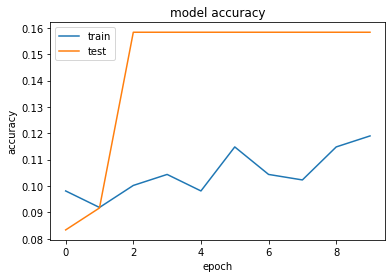

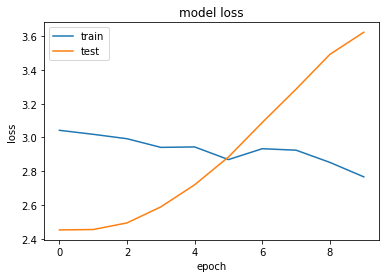

In [19]:
# 정확도 기록 시각화
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# 비용 함수 기록 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 4. Pretrained Model 배워보기
Pretrained Model이란 말 그대로 먼저 학습되어있는 or 정의되어있는 모델을 말합니다. 사용 방법은 크게 2가지가 있습니다<br>
이전의 세계적인 이미지 인식 대회에서 좋은 성능을 내고있는 모델을 가져와 1) 직접 학습할 수도 있고, 학습되어있는 모델을 2) 그대로 사용할 수도 있습니다.<br>
1번 방법의 경우 말 그대로 모델을 가져와 직접 학습하시면 됩니다. 하지만 2번 방법의 경우에는 이미지 인식 대회의 데이터로 학습한 모델입니다. <br>
이 경우에는 fine tuning이라는 기법을 통해 사용자의 데이터에 맞게 모델을 조정할 수 있습니다.<br>

### Fine tuning이란 무엇인가요?
fine tuning은 기존 학습된 모델의 전체를 학습시키는 것이 아닌 일부만을 학습시켜 미세 조정하는 학습 기법을 말합니다.<br>
일반적으로 Pretrained Model - MLP를 연결해 MLP만을 학습시켜 조정합니다. <br>
#### 그렇다면 입력 차원이 다른 경우에는 어떻게하나요?
Keras의 Pretrained Model은 모델이 요구하는 최소 차원이 있는데, 그 이상의 데이터라면 상관없습니다.<br>
최소 차원 이하의 데이터라면 이미지의 차원을 증가시켜야 합니다.

### 4_1. VGG16 모델을 사용해 Fine tuning 해보기
VGG16의 입력 최소 입력 차원은 200\*200\*3 이므로 앞 부분에 이미지 크기를 늘여주는 층을 추가해 입력 데이터의 차원을 2배로 늘려 사용하겠습니다.

In [20]:
from keras.applications.vgg16 import VGG16

from keras.models import load_model

In [21]:
# 앞 부분 추가 Layer
input_tensor = Input(shape = input_shape)
# 이미지 크기를 2배로 증가시킵니다.
upsample_layer = layers.UpSampling2D(size=(2,2))(input_tensor)

# 3개 차원을 추가해줍니다.
conv_layer_1 = layers.Conv2D(3, (3,3), padding='same', activation='relu')(upsample_layer)
drop_out_2 = layers.Dropout(0.5)(conv_layer_1)
batch_norm_2 = layers.BatchNormalization()(drop_out_2)

# Pretrained Model 설정
# 입력 데이터가 Pretrained Model의 입력과 동일하다면 include_top을 True로 주고 input_shape를 설정하지 않습니다.
# weight 매개변수는 fine tuning을 하고 싶으시다면, 'imagenet', 처음부터 학습시키거나 다른 학습된 모델을 가져오고 싶으시다면 None으로 설정합니다.
pretrained_model = VGG16(include_top = False, weights=None, input_shape = (input_shape[0]*2, input_shape[1]*2, 3))
# 준비된 학습된 모델을 불러옵니다.
pretrained_model.load_weights(join('weight', 'vgg16.hdf5'))
# Pretrained Model은 학습시키지 않도록 합니다.
pretrained_model.trainable=False
pretrained_layer = pretrained_model(batch_norm_2)
drop_out_3 = layers.Dropout(0.5)(pretrained_layer)
batch_norm_3 = layers.BatchNormalization()(drop_out_3)

flat_layer = layers.Flatten()(batch_norm_3)

# 뒷 부분 추가 MLP Layer
dense_1 = layers.Dense(256, activation='relu')(flat_layer)
drop_out_4 = layers.Dropout(0.5)(dense_1)
batch_norm_4 = layers.BatchNormalization()(drop_out_4)

dense_2 = layers.Dense(128, activation='relu')(batch_norm_4)
drop_out_5 = layers.Dropout(0.5)(dense_2)
batch_norm_5 = layers.BatchNormalization()(drop_out_5)

output_tensor = layers.Dense(10, activation='softmax')(batch_norm_5)

# 모델 정의
model = models.Model(input_tensor, output_tensor)
# 모델 생성(컴파일), 최적화기로 Adam 비용함수로 범주형 분류이므로 categorical_crossentropy를 사용합니다.
model.compile(optimizer='Adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])



모델의 구조를 살펴보겠습니다. pretrained model은 학습하지 않으므로 아래에 Non-trainable parameter의 수가 많은 것을 볼 수 있습니다.

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 161, 99, 1)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 322, 198, 1)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 322, 198, 3)       30        
_________________________________________________________________
dropout_8 (Dropout)          (None, 322, 198, 3)       0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 322, 198, 3)       12        
_________________________________________________________________
vgg16 (Model)                (None, 10, 6, 512)        14714688  
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 6, 512)        0         
__________

### 잘 학습된 모델을 저장하기 위한 콜백 함수 ModelCheckpoint Callback
#### monitor
잘 학습되었는지를 판단하는 기준은 monitor 매개변수에 지정을 할 수 있으며, 이번 실습에서는 검증 데이터의 비용 함수 값을 기준으로 저장하도록 합니다.<br>
#### save_best_only
학습을 진행하며, 가장 좋은 모델만을 저장하도록 지정합니다. 이전의 모델보다 현재의 모델이 좋지 않은 경우에는 저장을 하지 않습니다.

#### period
저장하는 주기를 말하는데, 일반적으로 callback 함수에서 period의 단위는 epoch 단위로 이루어집니다.

In [23]:
filepath = join('weight', 'VGG16_{epoch:02d}-{val_loss:.4f}.hdf5')
cb_ckpt = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='auto', period=1)

In [24]:
# 학습을 시작합니다. 1 epoch만 돌려보겠습니다.
model.fit(x_train, y_train,
         validation_data = [x_test, y_test],
         epochs=1,
         batch_size=32,
         verbose=2,
         callbacks=[cb_ckpt])

Train on 479 samples, validate on 120 samples
Epoch 1/1
 - 315s - loss: 2.8626 - acc: 0.1315 - val_loss: 5.1477 - val_acc: 0.0583

Epoch 00001: val_loss improved from inf to 5.14770, saving model to weight/VGG16_01-5.1477.hdf5


### 4_2. 동일한 구조로 미리 학습된 모델을 불러와 사용해보기
실습 수업에 직접 pretrained model을 학습시켜 결과를 살펴보기 제한적이므로 동일한 구조로 미리 학습해온 모델을 준비했습니다.

In [25]:
# 모델을 불러옵니다.
model.load_weights(join('weight', 'VGG16_0.2797.hdf5'))

# 검증 데이터의 값을 추정합니다.
pred_y = model.predict(x_test, batch_size=32)

이전의 전처리에서도 실제 정답 레이블은 벡터 형태로 있으므로 numpy.argmax() 함수를 통해 가장 큰 값만을 선택하겠습니다.<br>
당연히 모델의 출력값도 벡터 형태입니다. 확인해보겠습니다.

In [26]:
print(pred_y[0])
print(y_test[0])

[0.04395558 0.10435408 0.10234006 0.13576795 0.05835572 0.07901669
 0.32856017 0.04051016 0.06834841 0.03879114]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [27]:
# 추정한 y 벡터 중 가장 높은 값을 취해 레이블을 결정합니다.
pred_y = np.argmax(pred_y, axis=1)
# 정답 y 벡터 중 가장 높은 값을 취해 레이블을 결정합니다.
real_y = np.argmax(y_test, axis=1)

numpy.equal() 함수로 값을 비교한 다음, python에서 True는 정수 값 1이라는 특징을 이용해 정확도를 계산합니다. 

In [28]:
acc = (np.sum(np.equal(pred_y, real_y))/len(pred_y))*100

print('VGG16 Pretrained Model Acc : {:.2f}%'.format(acc))

VGG16 Pretrained Model Acc : 94.17%


### Reference
- Tensorflow Speech Recognition : https://www.kaggle.com/c/tensorflow-speech-recognition-challenge
- Pretrained Model : https://keras.io/applications/#applications